## 模型评估

1. 从验证集中挑选出分类正确的pair，按照置信度（预测概率）从高到低排序展示这些图片pair
2. 从验证集中挑选出分类错误的pair，按照置信度（预测概率）从高到低排序展示这些图片pair
3. 观察在不同的分类阈值下，验证集上的分类准确率和召回率（能给出判断结果的样本占比），找到合适的分类阈值
4. 编辑模型：输入一张图片，输出和100张基准图片进行比较后的得分

In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, concatenate, Activation, Add, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras import optimizers
from keras.utils import to_categorical

img_feature_a = Input(shape=(2048,))
img_feature_b = Input(shape=(2048,))

shared_fc_layer = Sequential([
    Dense(256, activation='relu', input_shape=(2048, )),
    BatchNormalization(),
    Dropout(0.5),
    #Dense(128, activation='relu', input_shape=(2048, )),
    #BatchNormalization(),
    #Dropout(0.5),
    Dense(1),
])

encoded_a = shared_fc_layer(img_feature_a)
encoded_b = shared_fc_layer(img_feature_b)

negated_encoded_b = Lambda(lambda x: -x, output_shape=(1,))(encoded_b)
diff = Add()([encoded_a, negated_encoded_b])

output = Activation("sigmoid")(diff)

model = Model(inputs=[img_feature_a, img_feature_b], outputs=output)

model.load_weights("./data/ranknet/ranknet.h5")

Using Theano backend.


In [3]:
# data prepare
import cPickle as pickle
import numpy as np
import lmdb
import random

env = lmdb.open("./data/features")
txn = env.begin()

def get_XY(dataset):
    img_pairs = []
    X1 = []
    X2 = []
    Y = []
    for img_a, s_a, img_b, s_b, cmpret in dataset:
        feature_a = txn.get(img_a)
        feature_b = txn.get(img_b)
        if feature_a is None or feature_b is None:
            continue
        feature_a = np.fromstring(feature_a, np.float32)
        feature_b = np.fromstring(feature_b, np.float32)
        img_pairs.append((img_a, s_a, img_b, s_b))
        X1.append(feature_a)
        X2.append(feature_b)
        Y.append(cmpret)
    X1 = np.array(X1)
    X2 = np.array(X2)
    Y = np.array(Y)
    return img_pairs, X1, X2, Y

batch_size = 128
#train_list = pickle.load(open("./data/ranknet/train.list", 'rb'))
valid_list = pickle.load(open("./data/ranknet/valid.list", 'rb'))
#print "# of trainset: %d"%len(train_list)
print "# of validset: %d"%len(valid_list)

#X1_train, X2_train, Y_train = get_XY(train_list)
img_pairs, X1_valid, X2_valid, Y_valid = get_XY(valid_list)

env.close()

# of validset: 4365


In [4]:
Y_predict = model.predict([X1_valid, X2_valid], batch_size=batch_size)

In [15]:
model.compile(optimizer="sgd",
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.evaluate([X1_valid, X2_valid], Y_valid)

4303/4303 [==============================] - 3s     


[0.65787338290745345, 0.60818033936742344]

In [12]:
# 验证acc
def acc_recall(Y_prob, Y_truth, thre=0.5):
    recall = 0
    acc = 0
    for i, p in enumerate(Y_prob):
        if p > thre:
            recall += 1
            if Y_truth[i] == 1:
                acc += 1
        elif p < 1-thre:
            recall += 1
            if Y_truth[i] == 0:
                acc += 1
    return acc*1.0/recall, recall*1.0/len(Y_prob)

print acc_recall(Y_predict[:, 0], Y_valid)

(0.6081803392981641, 1.0)


0.5 0.608180339298 1.0
0.51 0.614091470952 0.940041831281
0.52 0.616276007374 0.882407622589
0.53 0.620478575403 0.835231234023
0.54 0.629385307346 0.7750406693
0.55 0.637355584082 0.72414594469
0.56 0.6403175699 0.673251220079
0.57 0.649757553152 0.623053683477
0.58 0.659035159444 0.568440622821
0.59 0.671594982079 0.518707878224
0.6 0.679487179487 0.471299093656
0.61 0.685337726524 0.423193121078
0.62 0.690346083789 0.382756216593
0.63 0.69918699187 0.343016500116
0.64 0.708428246014 0.306065535673
0.65 0.713425129088 0.270044155241
0.66 0.717221135029 0.23750871485
0.67 0.717750826902 0.210783174529
0.68 0.725190839695 0.182663258192
0.69 0.732846715328 0.15919126191
0.7 0.749579831933 0.138275621659
0.71 0.749518304432 0.120613525447
0.72 0.761261261261 0.103183825238
0.73 0.77688172043 0.0864513130374
0.74 0.778501628664 0.0713455728561
0.75 0.813008130081 0.057169416686
0.76 0.791666666667 0.0446200325354
0.77 0.785714285714 0.0357889844295
0.78 0.767441860465 0.0299790843597
0.7

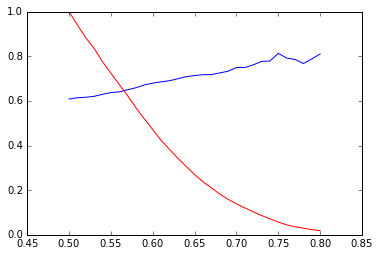

In [24]:
# 在不同阈值下，模型的准确率和召回率
%matplotlib inline
import matplotlib.pyplot as plt

ACC = []
RECALL = []
for thre in np.arange(0.5, 0.8, 0.01):
    acc, recall = acc_recall(Y_predict[:, 0], Y_valid, thre)
    print thre, acc, recall
    ACC.append(acc)
    RECALL.append(recall)
plt.plot(np.arange(0.5, 0.8, 0.01), np.array(ACC), 'b')
plt.plot(np.arange(0.5, 0.8, 0.01), np.array(RECALL), 'r')

In [26]:
# 分类正确的pair
thre = 0.5

POS_CASE = []
for i, p in enumerate(Y_predict[:, 0]):
    if (p > thre and Y_valid[i] == 1) or \
        (p < 1-thre and Y_valid[i] == 0):
        POS_CASE.append((img_pairs[i], p))

POS_CASE = sorted(POS_CASE, key=lambda x: x[1], reverse=True)

for (img_a, s_a, img_b, s_b), p in POS_CASE:
    print img_a, s_a, img_b, s_b, p

112406 9.0 114922 7.0 0.88393
79618 9.0 79717 7.0 0.843596
82928 8.0 82969 6.0 0.84352
103558 12.0 103537 7.0 0.837739
91290 8.0 91292 7.0 0.837197
59497 10.0 59505 7.0 0.836175
67162 10.0 66956 6.0 0.835959
33314 8.0 33381 7.0 0.833908
94084 6.0 100423 5.0 0.829688
63721 7.0 63668 6.0 0.828835
58100 8.0 58114 7.0 0.828717
100658 7.0 100074 6.0 0.827539
53253 8.0 53200 7.0 0.827358
32750 13.0 32778 7.0 0.826925
58812 8.0 58848 7.0 0.826407
96854 7.0 96903 6.0 0.826368
118618 9.0 118103 6.0 0.825756
18622 10.0 18499 8.0 0.825338
113294 10.0 113520 6.0 0.823937
46725 10.0 46793 7.0 0.81541
65777 7.0 65832 5.0 0.813085
72392 8.0 72352 7.0 0.812414
89073 8.0 88945 6.0 0.811656
97078 9.0 97142 6.0 0.81161
17211 8.0 17203 7.0 0.811492
25539 363.0 25507 8.0 0.80908
73301 12.0 73289 6.0 0.806532
23729 15.0 23694 7.0 0.802098
65066 18.0 64935 7.0 0.801387
26530 12.0 26486 7.0 0.800547
48409 11.0 48420 10.0 0.800219
42577 9.0 42461 7.0 0.798814
103534 10.0 103710 7.0 0.798342
20022 10.0 20069 8.

In [27]:
# 分类错误的pair
thre = 0.5

NEG_CASE = []
for i, p in enumerate(Y_predict[:, 0]):
    if (p > thre and Y_valid[i] == 0) or \
        (p < 1-thre and Y_valid[i] == 1):
        NEG_CASE.append((img_pairs[i], p))

NEG_CASE = sorted(NEG_CASE, key=lambda x: x[1], reverse=True)

for (img_a, s_a, img_b, s_b), p in NEG_CASE:
    print img_a, s_a, img_b, s_b, p

33294 7.0 33350 9.0 0.866713
36207 8.0 36240 9.0 0.861278
63120 6.0 63068 7.0 0.837541
33925 7.0 33917 8.0 0.832243
43121 8.0 43090 9.0 0.829917
40121 7.0 40165 9.0 0.817947
31300 8.0 31355 12.0 0.81349
119060 6.0 118921 7.0 0.806804
93909 6.0 98171 9.0 0.805937
70752 6.0 70763 7.0 0.799869
112365 6.0 112464 7.0 0.799471
24138 8.0 24151 12.0 0.789753
118502 5.0 118614 6.0 0.787467
42457 7.0 42574 8.0 0.78128
77920 6.0 97821 7.0 0.780583
32806 9.0 32809 15.0 0.778416
32627 8.0 32687 9.0 0.77811
100917 6.0 100429 8.0 0.76991
95101 7.0 95126 8.0 0.769778
107698 5.0 107952 6.0 0.769127
97829 6.0 97553 7.0 0.768333
46634 7.0 46783 8.0 0.762
96378 6.0 107181 7.0 0.754155
69440 6.0 69347 7.0 0.751215
107687 6.0 107881 7.0 0.747561
89685 7.0 89705 11.0 0.747144
68810 6.0 68720 7.0 0.746123
20060 10.0 20039 12.0 0.745845
80299 6.0 80151 7.0 0.74527
55098 6.0 54997 7.0 0.745006
42723 8.0 42759 9.0 0.744744
23435 7.0 23465 8.0 0.744276
97966 6.0 100532 7.0 0.743872
42156 7.0 42191 8.0 0.738827
11

In [70]:
# 将全连接层作为评分网络，输出照片的score
env = lmdb.open("./data/features")
txn = env.begin()

score_model = shared_fc_layer

def get_scores(imgids):
    valid_imgids = []
    features = []
    for imgid in imgids:
        feature = txn.get(imgid)
        if feature is None:
            continue
        feature = np.fromstring(feature, np.float32)
        features.append(feature)
        valid_imgids.append(imgid)
    return valid_imgids, score_model.predict(np.array(features))

def sigmoid(x):
    return 1.0/(1+np.exp(-x))

train_list = pickle.load(open("./data/ranknet/train.list", 'rb'))
imgids = list(set(map(lambda x: x[0], train_list)) | set(map(lambda x: x[2], train_list)))
print "# of imgs: %d"%len(imgids)
imgids, img_scores = get_scores(imgids)

env.close()

# of imgs: 74884


In [75]:
imgid2score = {}
score2imgid = {}
for imgid, score in zip(imgids, img_scores[:, 0]):
    score = sigmoid(score)
    imgid2score[imgid] = score
    score2imgid.setdefault(np.round(score*5), [])
    score2imgid[np.round(score*5)].append(imgid)
    
#for imgid, score in sorted(imgid2score.items(), key=lambda x: x[1], reverse=True):
#    print imgid, score
import random

for _s, _imgids in sorted(score2imgid.items(), key=lambda x: x[0], reverse=False):
    #print _s, len(_imgids)
    for _id in random.sample(_imgids, min(len(_imgids), 5)):
        print _s, _id

1.0 27648
1.0 12283
1.0 75326
1.0 49376
1.0 20488
2.0 87181
2.0 106281
2.0 70847
2.0 57942
2.0 98699
3.0 49782
3.0 74985
3.0 77009
3.0 40301
3.0 111625
4.0 57150
4.0 65388
4.0 37499
4.0 82701
4.0 107560
5.0 83618


In [55]:
-np.log(1/0.65-1)

0.61903920840622373

In [59]:
sigmoid(-1+0.619)-sigmoid(-1)

0.13694431051433775